# Home work: text classification
1) Tìm hiểu, nêu bài toán phân loại văn bản đa nhãn (tức là 1 input có thể thuộc về nhiều label).

2) Tìm hiểu phương pháp để giải quyết bài toán này. Trình bày về lý thuyết

3) Thực hiện code (được sử dụng Lib) trên dữ liệu tự thu thập (dữ liệu có sẵn).

So sánh các phương pháp khác nhau (biểu diễn khác nhau, model học máy khác nhau) bởi độ chính xác (accuracy) và tốc độ huấn luyện, tốc độ inference.

## Theory
- Multi-label text classification problem: This is a problem in the field of text classification where an input document can belong to multiple labels. For example, an online newspaper can be classified as political information, social, or both.


### Lib

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize

import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Snape\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Snape\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from wordcloud import WordCloud
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp_sparse

In [65]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

### Read file 

In [4]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [5]:
path = 'data/predict_tag/'
train = read_data("".join([path, 'train.tsv']))
validation = read_data("".join([path, 'validation.tsv']))
test = pd.read_csv("".join([path, 'test.tsv']), sep='\t') #NO tag

In [6]:
# train = read_data('data/train.tsv')
# validation = read_data('data/validation.tsv')
# test = pd.read_csv('data/test.tsv', sep='\t')

### Overview data

In [7]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [8]:
validation.head()

,title,tags
0,Why odbc_exec always fail?,"[php, sql]"
1,Access a base classes variable from within a c...,[javascript]
2,"Content-Type ""application/json"" not required i...","[ruby-on-rails, ruby]"
3,Sessions in Sinatra: Used to Pass Variable,"[ruby, session]"
4,"Getting error - type ""json"" does not exist - i...","[ruby-on-rails, ruby, json]"


In [9]:
print(train.shape)
print(validation.shape)
print(test.shape)

(100000, 2)
(30000, 2)
(20000, 1)


In [10]:
print(train['title'][22])
print(train['tags'][22])

make 2 thumbnails at once in codeigniter
['php', 'image', 'codeigniter']


In [11]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [12]:
X_train[0], y_train[0]
# X_val[0], y_val[0]

('How to draw a stacked dotplot in R?', ['r'])

## Text preprocessing

### Cleaning text

In [13]:
# Regular expressions for cleaning text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')  # Remove characters in this set with a space
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')           # Remove any character that is not alphanumeric or a space
STOPWORDS = set(stopwords.words('english'))            # Set of English stopwords

# Function to prepare text data
def text_prepare(text):
    text = text.lower()                                # Convert text to lowercase
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)      # Replace specified characters with a space
    text = re.sub(BAD_SYMBOLS_RE, '', text)            # Remove symbols not allowed
    token_words = word_tokenize(text)                  # Tokenize the text into words
    filtered_words = [word for word in token_words if word not in STOPWORDS]  # Remove stopwords
    text = ''
    for word in filtered_words:                       
        if word != filtered_words[len(filtered_words)-1]:  # If not the last word, add a space after the word
            text = text + word + ' '
        else:                                          # If it's the last word, don't add a space after it
            text = text + word
    return text  # Return the cleaned text

In [14]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [15]:
print(X_train[:3])
print("--------------------")
print(y_train[:3])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app']
--------------------
[list(['r']) list(['php', 'mysql']) list(['c#'])]


### Words tag counter

In [16]:
tags_counts = Counter() #{}
words_counts = Counter() #{}

for sentence in X_train:
    for word in sentence.split():
        words_counts[word] += 1

for l in y_train:
    for tag in l:
        tags_counts[tag] += 1

In [17]:
words_counts.most_common(5), tags_counts.most_common(5)

([('using', 8239), ('c', 5767), ('php', 5577), ('java', 5473), ('file', 4936)],
 [('javascript', 19078),
  ('c#', 19077),
  ('java', 18661),
  ('php', 13907),
  ('python', 8940)])

(-0.5, 1599.5, 799.5, -0.5)

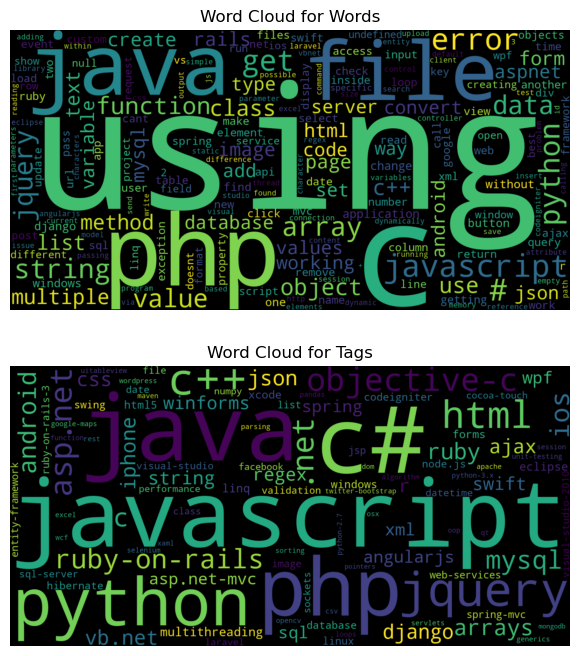

In [18]:
words_dict = dict(words_counts)
tags_dict = dict(tags_counts)

# Create word clouds
word_cloud_words = WordCloud(width=1600, height=800).generate_from_frequencies(words_dict)
word_cloud_tags = WordCloud(width=1600, height=800).generate_from_frequencies(tags_dict)

# Plot word cloud for words
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.imshow(word_cloud_words, interpolation='bilinear')
plt.title('Word Cloud for Words')
plt.axis('off')

# Plot word cloud for tags
plt.subplot(2, 1, 2)
plt.imshow(word_cloud_tags, interpolation='bilinear')
plt.title('Word Cloud for Tags')
plt.axis('off')

### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### I. Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}  ---  ATTENTION THIS LINE

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary 
    'are': [1, 0, 0, 1]    # 'are': 3
    'you': [1, 1, 0, 1]     # 'you': 1

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [19]:
len(words_counts), len(tags_counts)

(33807, 100)

In [28]:
# WORDS_TO_INDEX

In [35]:
dict_size = 5000
# Sort words_counts by frequency and select the most common words
dict_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:dict_size]
# Convert the sorted list of words into a single string separated by commas, then split it into a list
dict_words = ','.join(word for word, _ in dict_words).split(',')

# Create a dictionary mapping words to their indices
WORDS_TO_INDEX = { dict_words[i]:i for i in range(len(dict_words) ) }

# Create a dictionary mapping indices to words
INDEX_TO_WORDS = { i:dict_words[i] for i in range(len(dict_words) ) }
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    
    for myword in text.split():
      # Check if the word is in the dictionary and set the corresponding index to 1
      for key,value in words_to_index.items():
        if myword==key:
          result_vector[value]=1
    
    # Convert the result vector to a list
    result_vector=result_vector.tolist()
    # Convert each element in the result vector to an integer
    result_vector=[int(item1) for item1 in result_vector]
    return result_vector

In [33]:
# Test example
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans):
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [34]:
print(test_my_bag_of_words())

Basic tests are passed.


In [38]:
# WORDS_TO_INDEX
# INDEX_TO_WORDS

In [39]:
## time : < 6m55
DICT_SIZE=5000

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [47]:
# [0,0,0,1......0, 1] -  5000 col
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.sum(row)
print('Shape: ', X_train_mybag[10].toarray().shape)
print('BagOfWords non zero count: {}'.format(str(non_zero_elements_count)))

Shape:  (1, 5000)
BagOfWords non zero count: 7


In [45]:
X_train_mybag[10].toarray()

(1, 5000)

#### II. TF-IDF
- The second method enhances the bag-of-words model by considering the overall word frequencies within the corpora. This aids in penalizing overly common words and creates an improved feature space.

In [49]:
def tfidf_features(X_train, X_val, X_test):
    """
    X_train, X_val, X_test — samples
    return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with appropriate parameters
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, token_pattern='(\S+)', ngram_range=(1, 2))
    
    # Fit the vectorizer on the training set
    X_train = tfidf_vectorizer.fit_transform(X_train)
    
    # Transform the validation and test sets using the fitted vectorizer
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    # Return the transformed sets and the vocabulary
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_


In [50]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

#### Preparing labels for multilabel classifier
- As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s.

In [62]:
mlb = MultiLabelBinarizer(classes= sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

## Training a classifier
- Logistic Regression
- Navie Bayes
- KNN

In [68]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [69]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    ######################################
    ######### YOUR CODE HERE #############
    clf = OneVsRestClassifier(LogisticRegression(penalty='l2',C=10))
    clf.fit(X_train,y_train)
    
    return clf
    ######################################    

#### Train

In [70]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

c:\Users\Snape\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  method="L-BFGS-B",
c:\Users\Snape\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  method="L-BFGS-B",
c:\U

## Predict: 
- You will need two types of predictions: labels and scores.

In [71]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [72]:
y_val_predicted_labels_mybag.shape

(30000, 100)

In [73]:
y_val_predicted_scores_mybag.shape

(30000, 100)

In [74]:

y_val.shape

(30000, 100)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [75]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(6):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	c#


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	ruby


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	




## Test
1. Mybag

In [96]:
y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
y_test_predicted_scores_mybag = classifier_mybag.decision_function(X_test_mybag)

In [112]:
y_test_pred_inversed_mybag = mlb.inverse_transform(y_test_predicted_labels_mybag)

2. TF-IDF

In [110]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)

In [111]:
y_test_pred_inversed_tfidf = mlb.inverse_transform(y_test_predicted_labels_tfidf)

In [114]:
data = {
    'title': test['title'].values,
    'mybag': y_test_pred_inversed_mybag,
    'tfidf': y_test_pred_inversed_tfidf
}

df = pd.DataFrame(data)

In [115]:
df.head(10)

,title,mybag,tfidf
0,Warning: mysql_query() expects parameter 2 to ...,"(mysql, php)","(mysql, php)"
1,get click coordinates from <input type='image'...,"(javascript, jquery)","(javascript, jquery)"
2,How to implement cloud storage for media asset...,(),()
3,What is catcomplete in jQuery's autocomplete p...,"(javascript, jquery)","(javascript, jquery)"
4,Error building Android app with Cordova 3.1 CLI,"(android,)","(android, java)"
5,How to Parse XML File in PHP,"(php, xml)","(parsing, php, xml)"
6,Uploading files via JSON Post request to a Web...,"(ajax, json, php, web-services)","(json,)"
7,Adding rows to JTable in the right order.,"(java, swing)","(java, swing)"
8,How to read input file in Python?,"(python,)","(file, python)"
9,PDF generation from an html containing images ...,"(html,)","(html,)"


## Evaluation
To evaluate the results we will use several classification metrics:

- Accuracy
- F1-score
- Area under ROC-curve
- Area under precision-recall curve

Micro-averaging aggregates the contributions from all the classes:

$TPR=\frac{\sum_{c}TP_c}{\sum_{c}(TP_c + FN_c)}$ ;

$FPR=\frac{\sum_{c}FP_c}{\sum_{c}(FP_c + TN_c)}$ .

In [77]:
def print_evaluation_scores(y_val, predicted):
    
    
    print("Accuracy is {}".format(accuracy_score(y_val,predicted)))
    
    
    ##Calculate F1 metrics for each label, 
    ##and find their average weighted by support (the number of true instances for each label)
    print("F1-score is {}".format(f1_score(y_val, predicted, average='weighted')))
    
    print("Average_Precision_score is {}".format(average_precision_score(y_val, predicted, average='weighted')))

In [78]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy is 0.35083333333333333
F1-score is 0.6522380653670452
Average_Precision_score is 0.5018521606863069
Tfidf
Accuracy is 0.3627
F1-score is 0.6530788747297325
Average_Precision_score is 0.5090897345126476


## Plot ROC 

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_auc(y_test, y_score, n_classes):  
    """Plots ROC curve for micro and macro averaging."""
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area     
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes 
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], 
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"], 
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(0,3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of ROC to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# classifier_mybag = train_classifier(X_train_mybag, y_train)
# classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [ ]:
def print_evaluation_scores(y_val, predicted):
    
    
    print("Accuracy is {}".format(accuracy_score(y_val,predicted)))
    
    
    ##Calculate F1 metrics for each label, 
    ##and find their average weighted by support (the number of true instances for each label)
    print("F1-score is {}".format(f1_score(y_val, predicted, average='weighted')))
    
    print("Average_Precision_score is {}".format(average_precision_score(y_val, predicted, average='weighted')))

In [ ]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy is 0.35083333333333333
F1-score is 0.6522380653670452
Average_Precision_score is 0.5018521606863069
Tfidf
Accuracy is 0.3627
F1-score is 0.6530788747297325
Average_Precision_score is 0.5090897345126476


C:\Users\Snape\AppData\Local\Temp\ipykernel_22308\2738413760.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


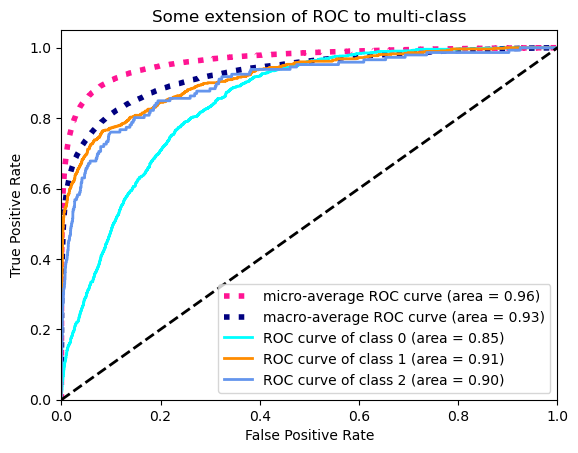

In [89]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

C:\Users\Snape\AppData\Local\Temp\ipykernel_22308\2738413760.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


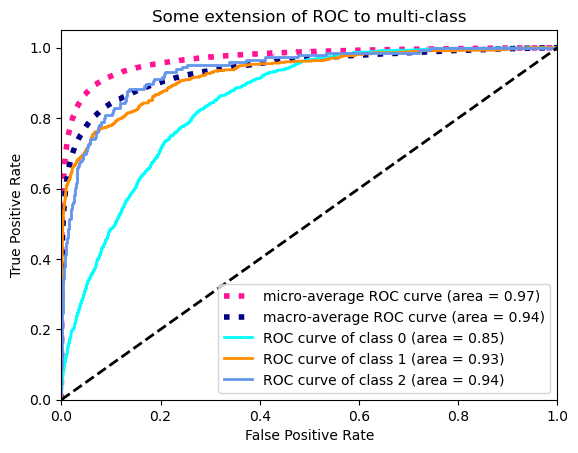

In [90]:
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)